# Trabalho Prático I - Aprendizado de Máquina
## Classificação de Exoplanetas

### Aluno
Samuel da Silva Guimarães (Matrícula: 2018722292)

### Objetivo
O objetivo deste trabalho prático é de praticar os conceitos aprendidos na disciplina e de adquirir experiência no uso de alguns dos principais métodos de classificação, na avaliação de modelos e na interpretação e apresentação de resultados de experimentos. Os métodos serão testados em um problema de classificação binária de candidatos a exoplanetas, chamados de Kepler Object of Interest (KOI), encontrados pela sonda espacial Kepler da NASA.

### Importação e Constantes

Primeiramente vamos importar as bibliotecas de tratamento de dados (numpy e pandas), de geração de gráficos (matplotlib), os classificadores pedidos pelo enunciado e, por fim, métodos para possibilitar a execução da validação cruzada e uma possível redução de dimensionalidade.
Além das importações também criamos algumas constantes que usaremos ao longo do trabalho. O nome do arquivo de entrada, a coluna do arquivo .csv que é a variável a ser predita (classe do KOI), o campo de nome do KOI que deverá ser eliminado, número de dimensões caso haja redução e o número de folds a ser usado pela validação cruzada.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from itertools import product
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
#Constants

INPUT_FILE = 'koi_data.csv'
TARGET_VAR = 'koi_disposition'
NAME_VAR = 'kepoi_name'
N_FEATURES = 25 #of 41 possible
NUM_CV = 5

### Leitura dos dados

Com tudo preparado para ser executado agora começamos o trabalho em si. Primeiramente vamos ler os dados, depois verificar quantas linhas e colunas temos nos dados para notarmos quaisquer problemas na execução dos classificadores, além de confirmar se temos dados completos.

In [3]:
#Reading the file
df = pd.read_csv(INPUT_FILE)

#Evaluating the received data
print("Number of lines: {}".format(df.shape[0]))
print("Number of columns: {}".format(df.shape[1]))
print("Missing data: {}".format(df.isnull().sum().sum()))

names = df.pop(NAME_VAR)
features = list(df.columns)
features.remove(TARGET_VAR)

Number of lines: 5202
Number of columns: 43
Missing data: 0


Vemos claramente que temos uma tabela sem dados faltantes de 5202 linhas e 43 colunas, sendo que 41 features poderão ser usadas, excluindo o nome e a classe que também são colunas.

#### Distribuição interna dos dados
Agora vamos verificar as distribuições dos dados para ver a necessidade de normalização dos dados, e vermos se temos classes desbalanceadas, o que pode afetar o desempenho de alguns classificadores. Primeiro vemos a distribuição das classes, depois vemos graficamente as distribuições de cada feature, além de verificar as estatísticas de cada uma.

In [4]:
display((df[TARGET_VAR].value_counts()/len(df)*100).round(2).to_frame(TARGET_VAR +" (%)").T)

,FALSE POSITIVE,CONFIRMED
koi_disposition (%),59.55,40.45


Temos classes com um leve "desequilíbrio" em direção a classe de um KOI que é um FALSO POSITIVO, mas sendo 9.55 % de diferença, podemos ver que não temos nada grave, já que com nem 10% de diferença temos dados o bastante da classe minoritária para evitar que a classificação seja boa somente por classificar todos os dados como FALSO POSITIVO.

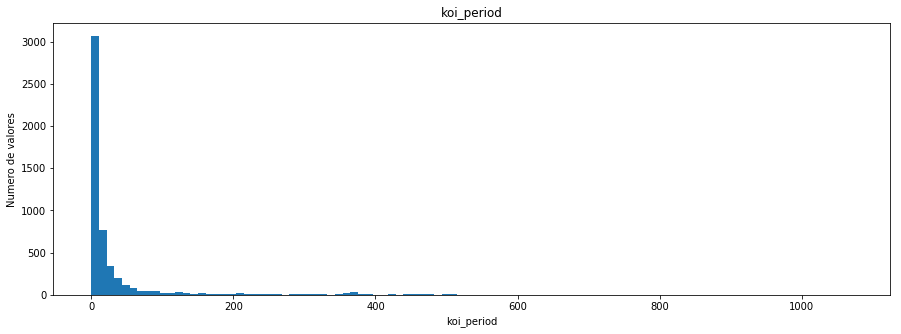

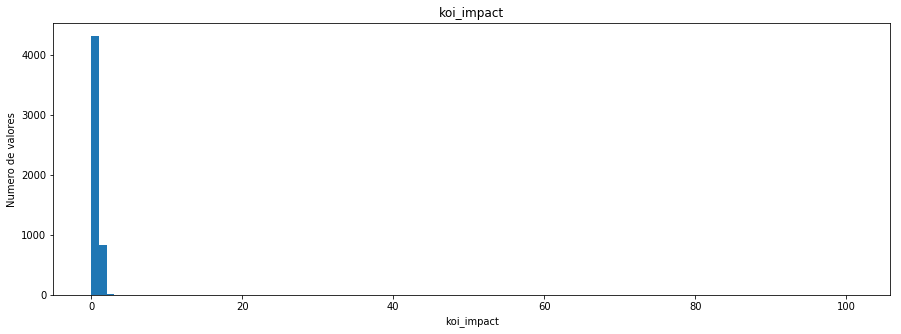

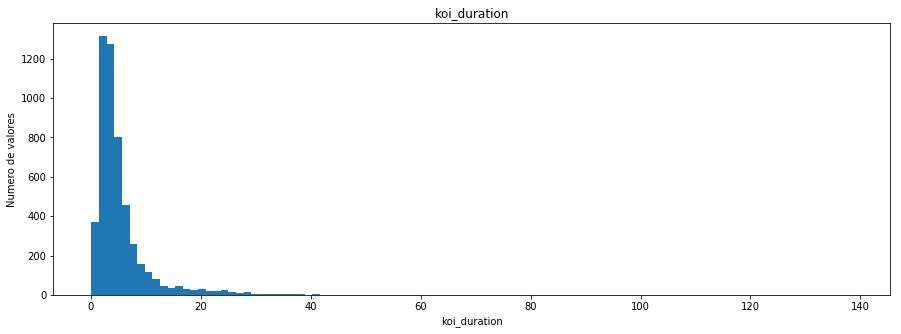

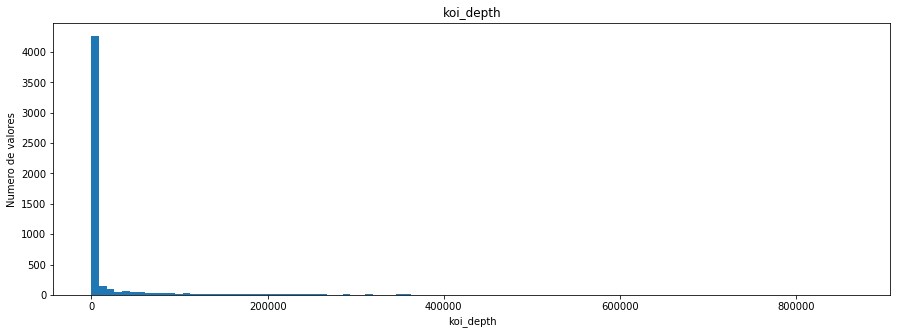

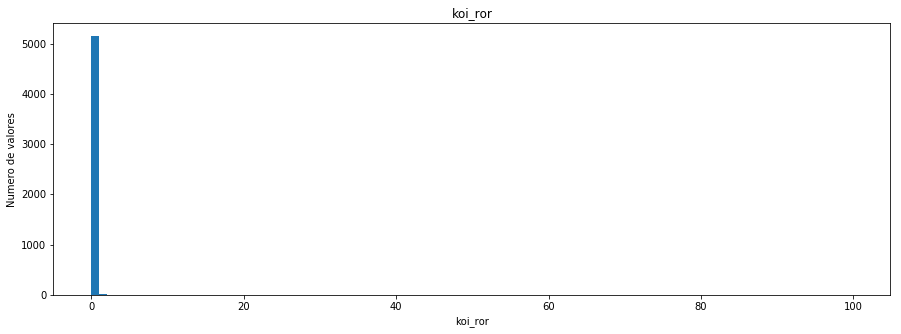

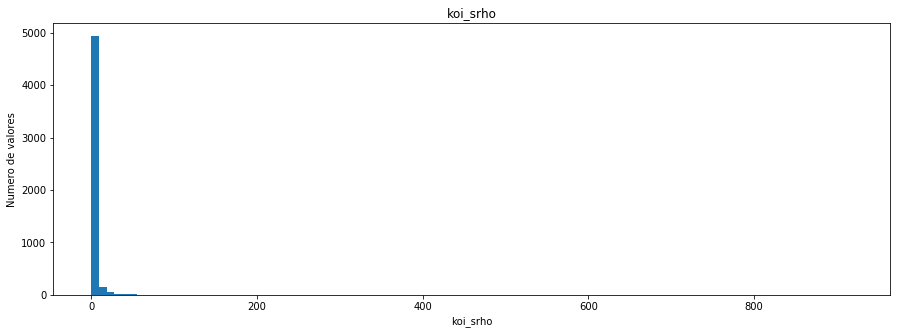

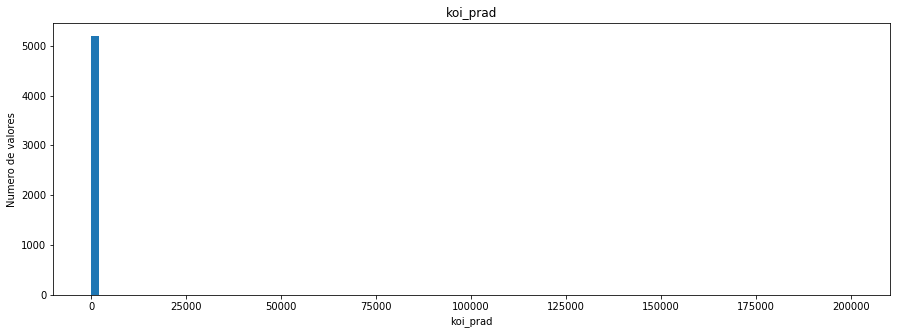

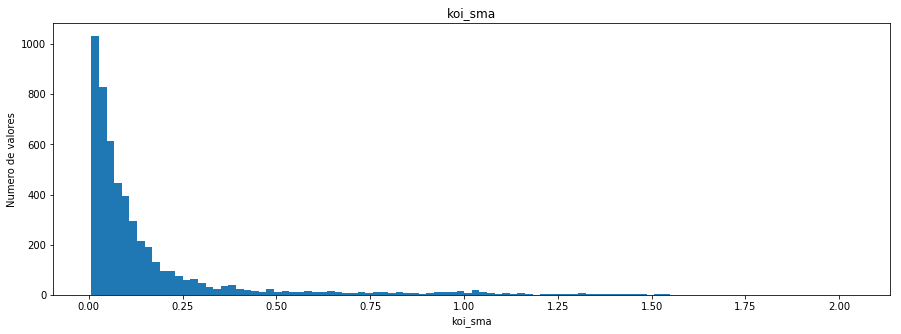

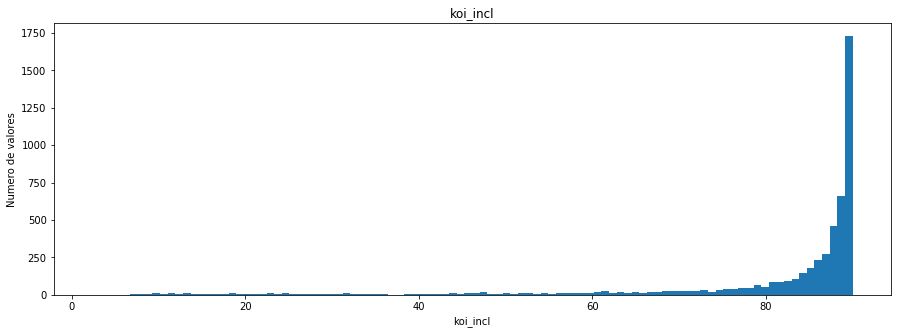

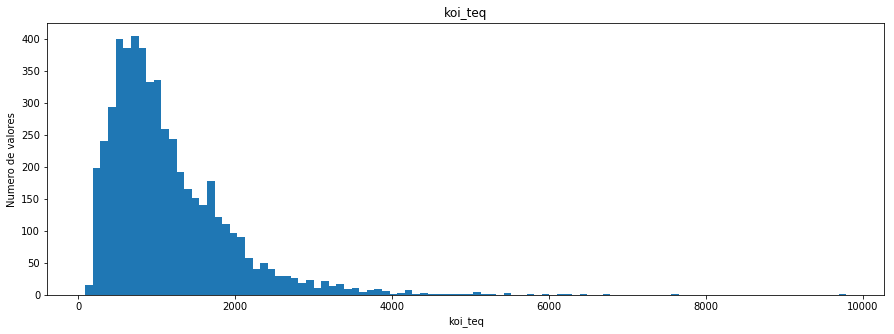

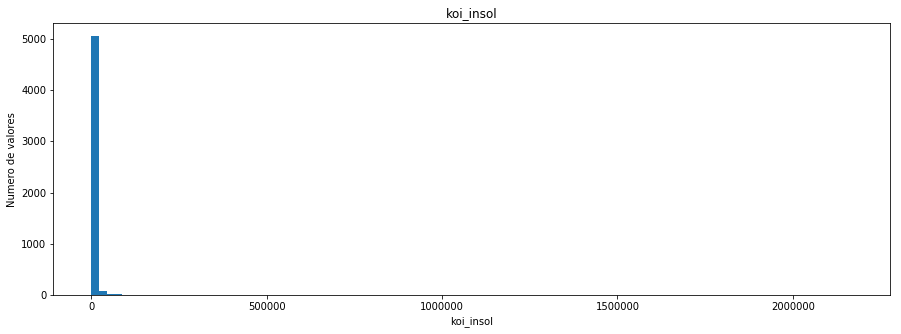

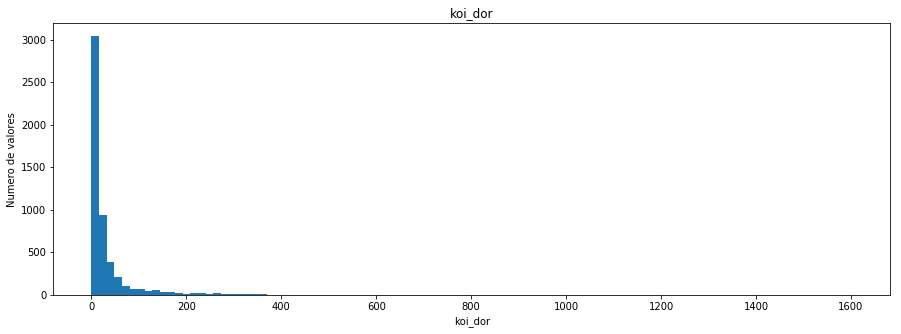

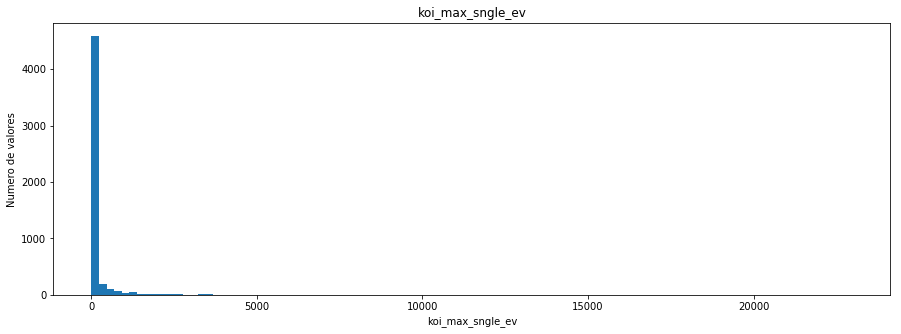

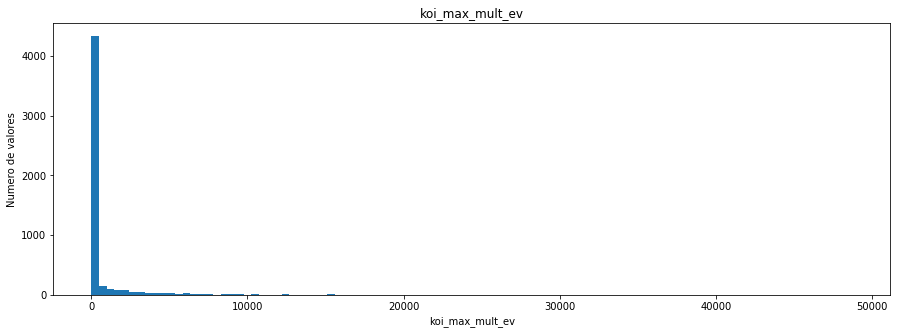

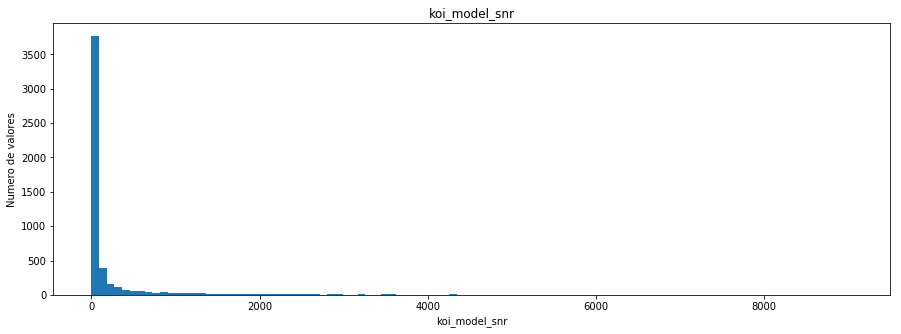

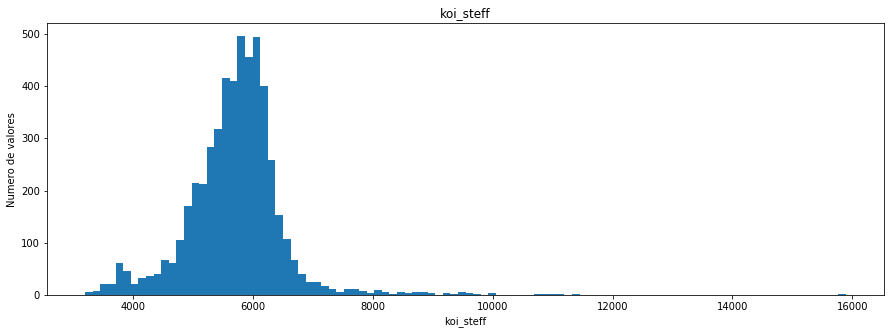

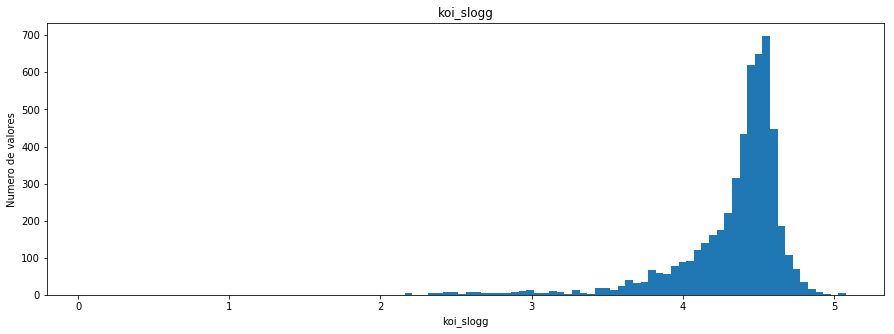

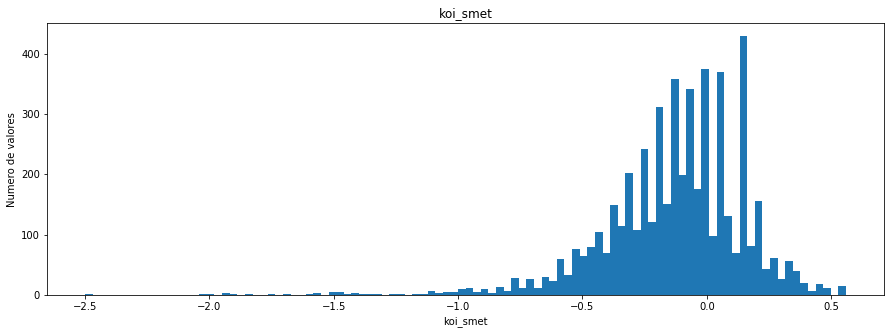

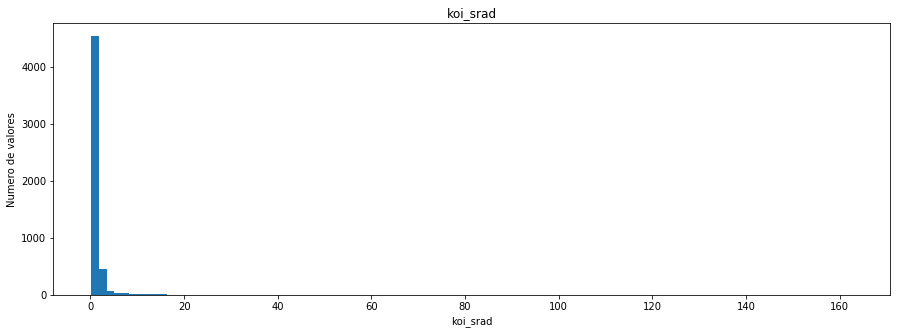

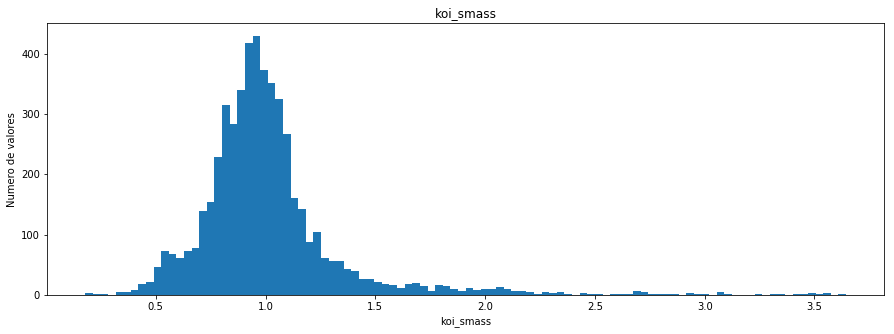

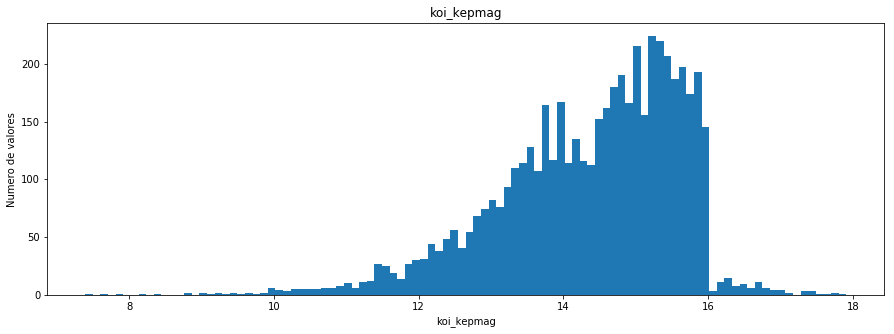

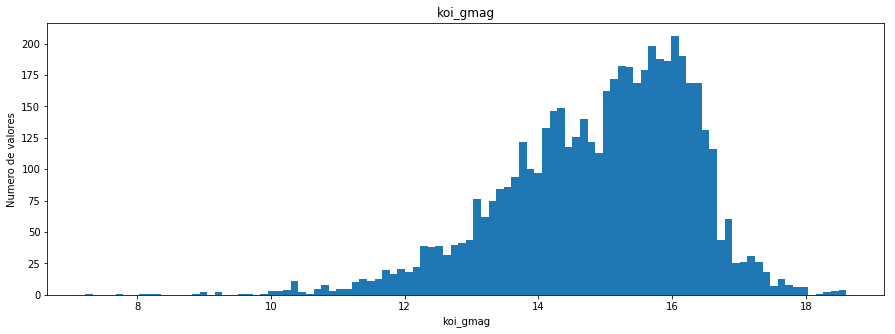

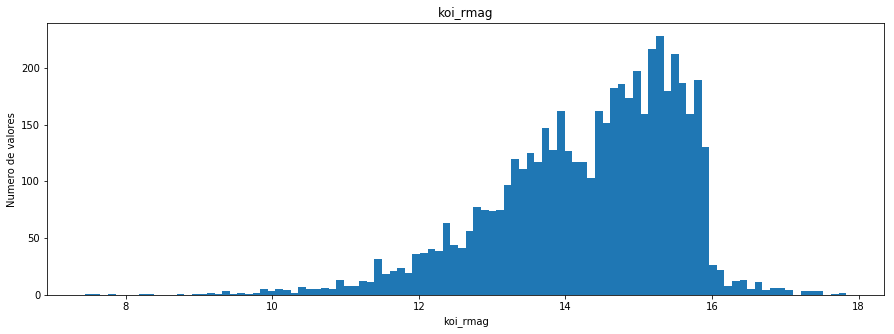

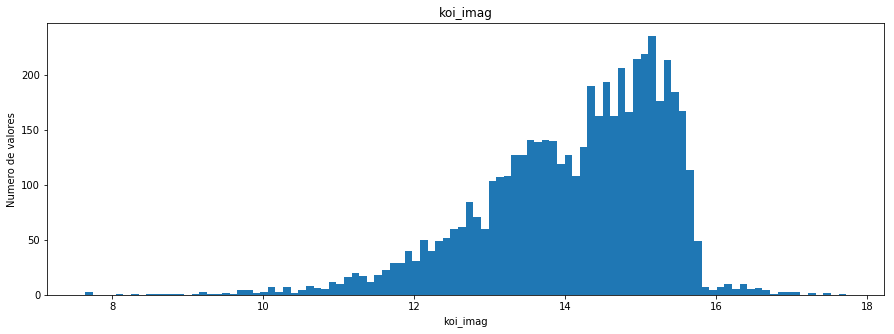

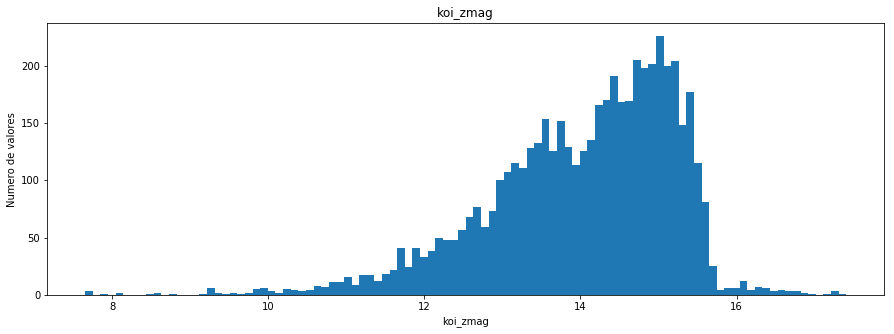

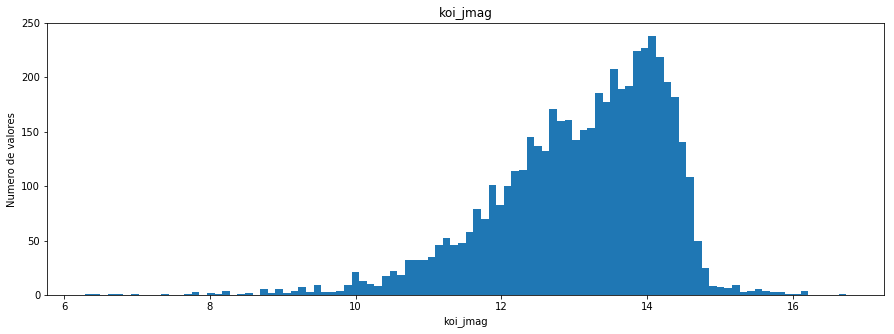

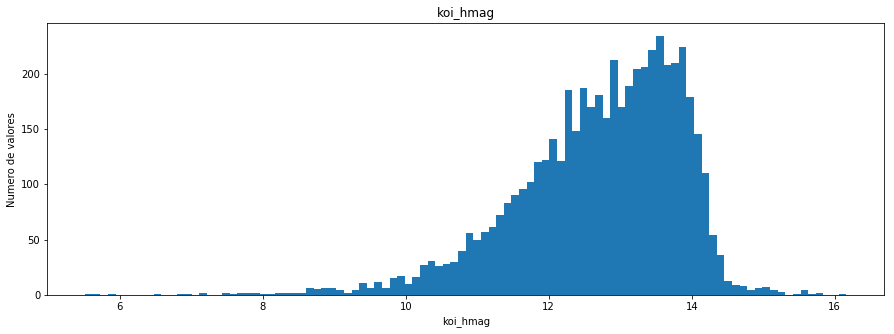

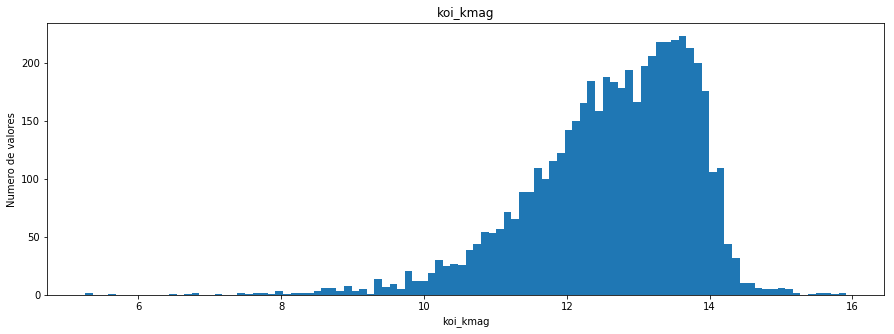

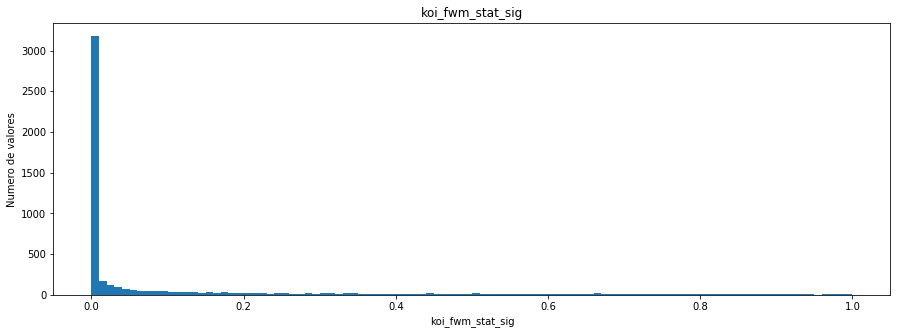

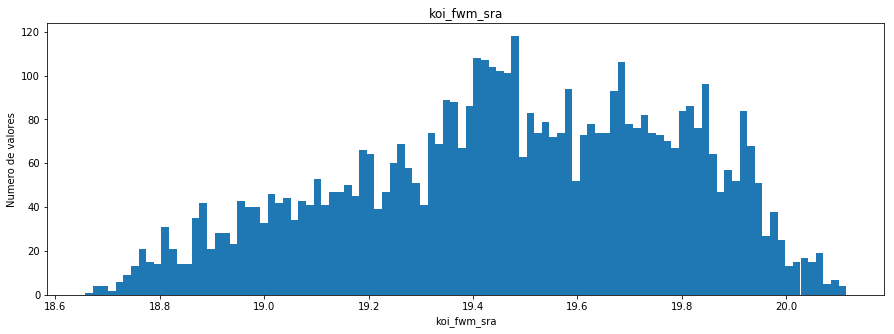

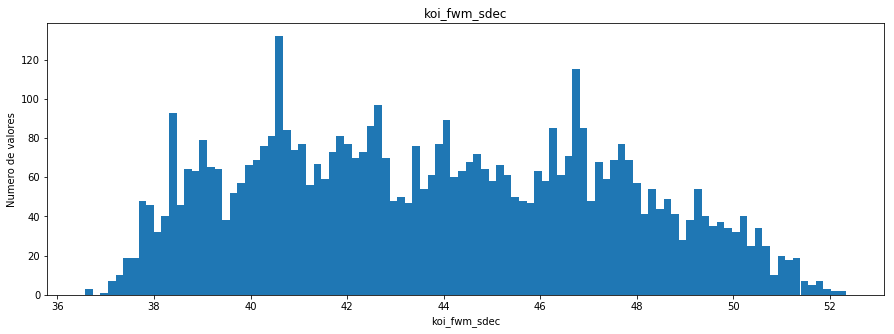

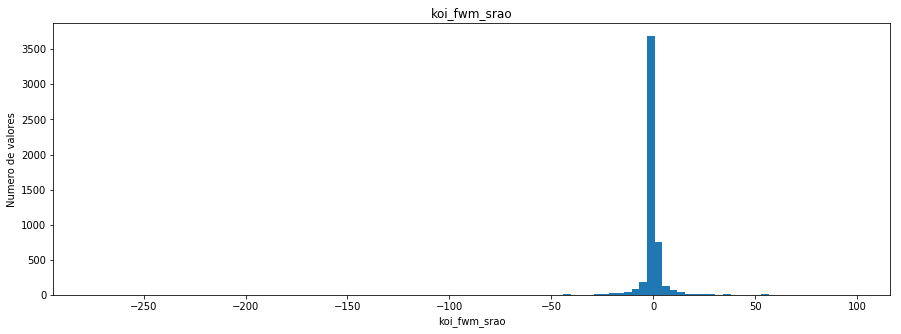

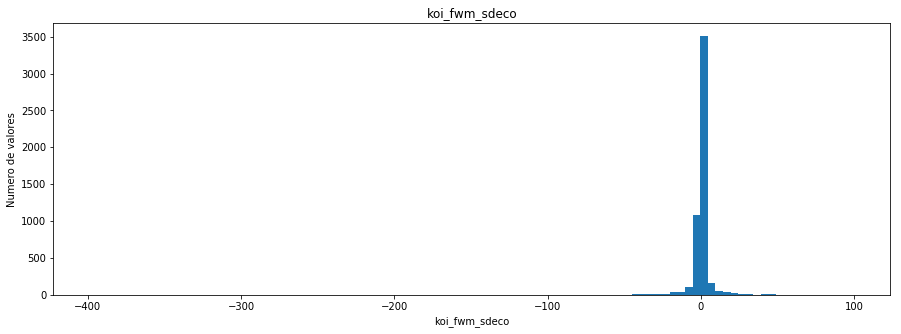

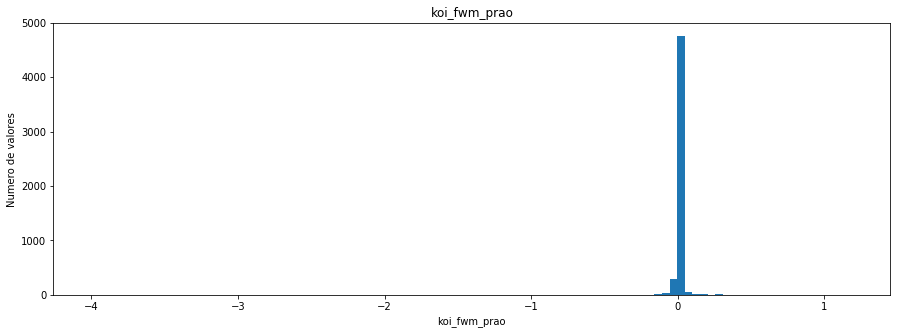

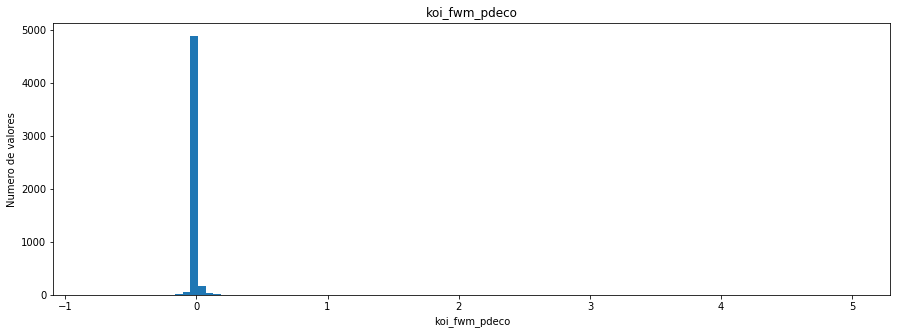

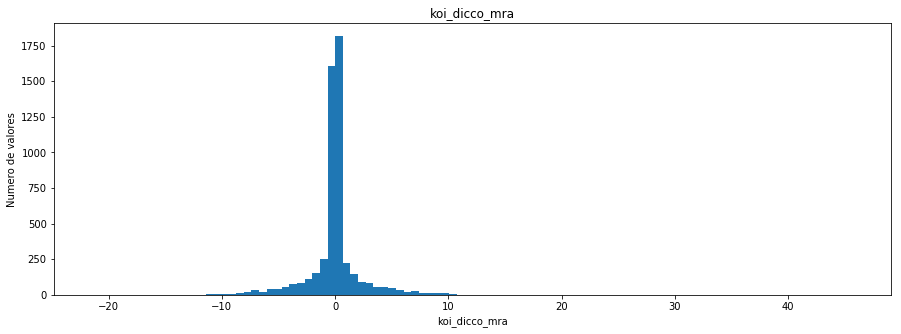

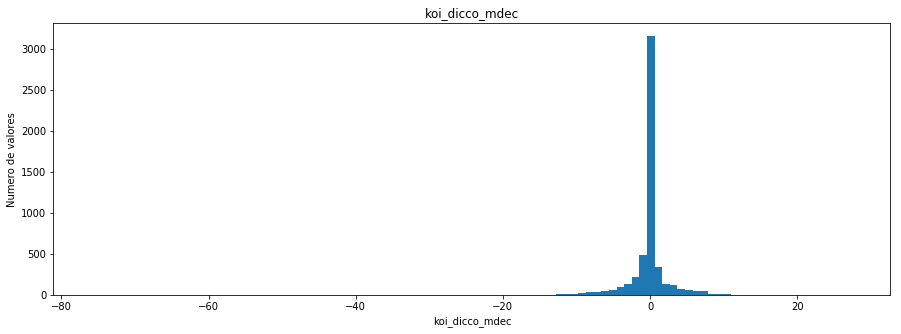

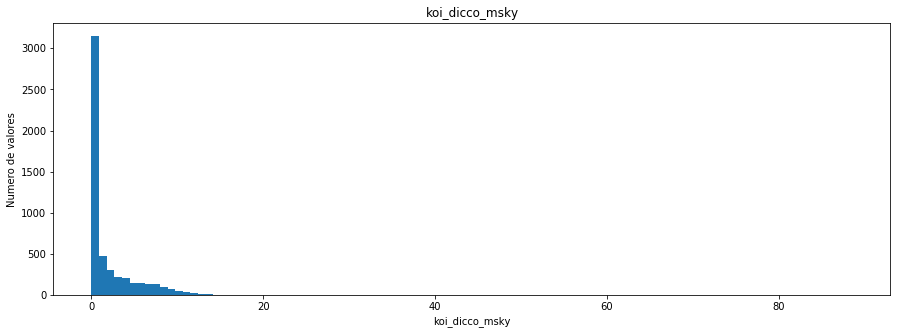

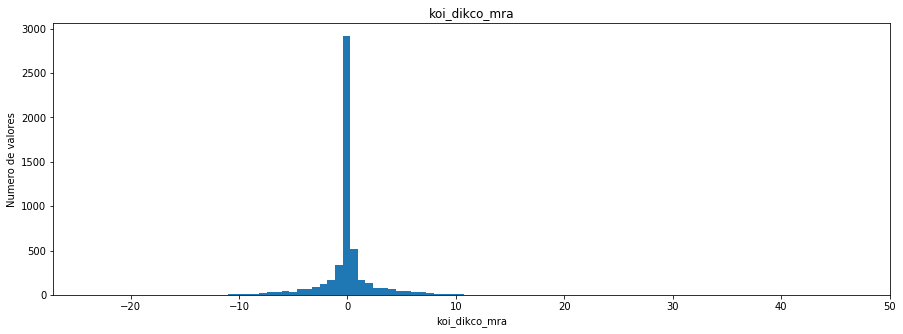

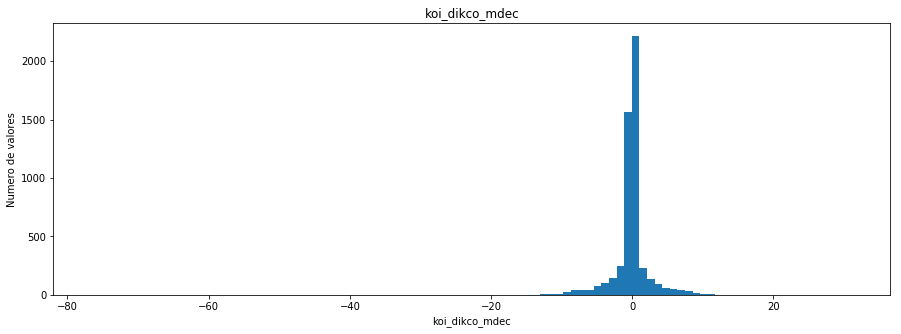

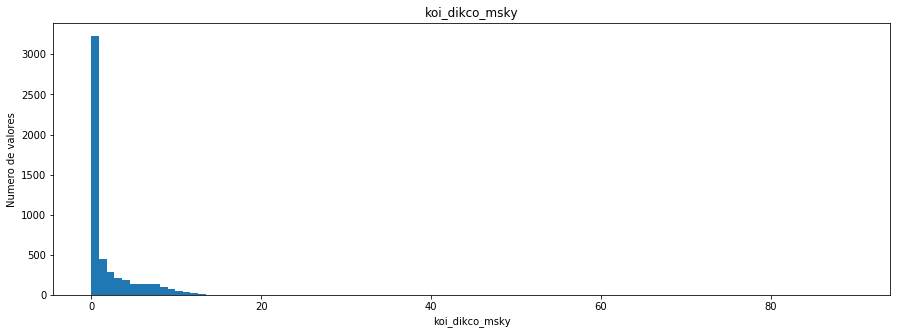

In [5]:
for c in features:
    plt.figure(figsize=(15, 5))
    plt.hist(df[c], bins=100)
    plt.title(c)
    plt.xlabel(c)
    plt.ylabel("Numero de valores")
    plt.show()

In [6]:
df.loc[:,features].mean().to_frame('Media').join(df.loc[:,features].std().to_frame('Desvio Padrão')).join((df.loc[:,features].std()/df.loc[:,features].mean()).to_frame('CV'))

,Media,Desvio Padrão,CV
koi_period,37.032237,88.417985,2.387595
koi_impact,0.717106,2.628207,3.665020
koi_duration,5.607025,6.962634,1.241770
koi_depth,21340.318993,66989.808550,3.139119
koi_ror,0.235205,2.586213,10.995581
koi_srho,3.415370,25.131368,7.358316
koi_prad,112.230798,3699.799318,32.965990
koi_sma,0.158146,0.241792,1.528916
koi_incl,81.181413,16.308839,0.200894
koi_teq,1143.721069,775.788868,0.678303


O que podemos ver nessas duas análises, uma visual e outra estatística, é que os dados possuem escalas bem diferentes, além de variar em distribuição, tendo features com Coeficiente de Variação (CV) de diferentes níveis. Algumas features são bem concentradas em torno da média, e outras mais dispersas. Isso também pode ser visto na análise visual, onde os formatos dos histogramas demonstram que existem alguns padrões comuns de curvas, algumas que podem se aproximar de normais, talvez por serem dados agregados que pelo teorema central do limite criam uma distribuição normal, outras mais próximas de exponenciais, em ambos os casos com diferentes graus de concentração em torno da média.

O que se torna claro é que com escalas tão distintas devemos usar de normalização para que nenhuma feature seja mais evidenciada, somente devido a sua escala, por principalmente por algoritmos como SVM ou KNN, que estão intrinsecamente ligados a ideia de espaço vetorial de features, do que algoritmos focados em um espaço de probabilidades (Naive Bayes) ou em árvores de decisão (Decision Trees, Random Forests e Gradient Boosting Trees).

Como temos 41 dimensões nos dados, o que não é uma quantidade tão grande, mas que ainda assim pode não ser desprezivel, podemos lançar mão de redução da dimensionalidade. As distribuições semelhantes podem indicar features que são reduntantes e que podem também enviesar os classificadores. Todavia, devido ao fato de não termos uma quantidade absurda de features, vamos inicialmente utilizar todas elas, e posteriormente avaliar o uso da redução nos dados.

#### Tratamento das classes
Como devemos ver as classes como números, nesse caso, binários, precisamos transformar as classes em texto por 0 ou 1. Para confirmar o resultado correto imprimimos uma amostra do resultado.

In [7]:
df[TARGET_VAR] = (df[TARGET_VAR] == "CONFIRMED").astype(int)

print("Resultado:")

display(df[[TARGET_VAR]].sample(10))

Resultado:


,koi_disposition
3632,0
4292,0
1749,1
2000,1
3606,0
4384,0
512,1
4931,0
1476,0
4929,0


### Normalização
Para normalizar os dados usaremos duas técnicas: a normalização de escala e a normalização da distribuição t. Usaremos a primeira para os dados que serão reduzidos, pois os algoritmos de redução de dados se utilizam da variância dos dados para determinar quais features capturam mais da diversidade (ou variação) dos dados e que portanto não deveriam ser eliminadas. Essa normalização faz com que os dados estejam na escala de -1 a 1, e para que não haja viés também devido a média, faremos que os dados tenham média igual a 0. A segunda técnica é mais tradicional, fazendo os dados terem média igual a 0 e desvio padrão igual a 1.

In [8]:
# Recreates the list with the features
features = list(df.columns)
features.remove(TARGET_VAR)

#Makes a copy of the data for data reduction
reduced_df = df.copy()

#Standard Score Normalization
#Subtracts the mean
df[features] = df[features] - df[features].mean()
#Divides by the standard deviation
df[features] = df[features] / df[features].std()

#Range Normalization for future data reduction
#Subtracts the mean
reduced_df[features] = reduced_df[features] - reduced_df[features].mean()
#Divides by the range of all values
reduced_df[features] = reduced_df[features] / (reduced_df[features].max()-reduced_df[features].min())


print("Resultado:")
df_mean = df[features].mean().round(2).to_frame("Mean")
df_std = df[features].std().round(2).to_frame("Std")
df_mean2 = reduced_df[features].mean().round(2).to_frame("Mean (for dim. reduction)")
df_std2 = reduced_df[features].std().round(2).to_frame("Std (for dim. reduction)")
display(df_mean.join(df_std).join(df_mean2).join(df_std2))

Resultado:


,Mean,Std,Mean (for dim. reduction),Std (for dim. reduction)
koi_period,-0.0,1.0,-0.0,0.08
koi_impact,-0.0,1.0,-0.0,0.03
koi_duration,0.0,1.0,0.0,0.05
koi_depth,-0.0,1.0,-0.0,0.08
koi_ror,-0.0,1.0,-0.0,0.03
koi_srho,0.0,1.0,0.0,0.03
koi_prad,0.0,1.0,0.0,0.02
koi_sma,0.0,1.0,0.0,0.12
koi_incl,0.0,1.0,0.0,0.19
koi_teq,0.0,1.0,0.0,0.08


### Validação Cruzada
Agora com os dados preprocessados em mãos vamos dividir os dados para a validação cruzada, dividindo os dados igualmente para todos os classificadores. Além disso também vamos dividir os dados na versão de dimensionalidade reduzida para posterior avaliação do impacto do número de features, e também vamos criar as funções que executaram os classificadores em cada fold da validação.

Primeiro dividimos os dados:

In [9]:
#Divides the data in folds for the Cross Validation
idx = list(df.index)
np.random.shuffle(idx)
X = df.loc[idx, features]
Y = df.loc[idx, TARGET_VAR]
kf = StratifiedKFold(n_splits=NUM_CV)

Agora executamos a redução de dimensionalidade de fato ao dividir também os dados reduzidos:

In [10]:
skb = SelectKBest(f_classif, N_FEATURES)
skb = skb.fit(reduced_df[features], reduced_df[TARGET_VAR])
X_reduced = pd.DataFrame(skb.transform(reduced_df.loc[idx, features]))

Por fim criamos as funções para a execução completa da validação cruzada.
#### Função para executar um classificador com parâmetros especificos nos folds:

In [11]:
def my_CV_train_test(classifier,X,Y,clf_params):
    train_results = []
    test_results = []
    y_results = []
    prob_results = []
    y_correct = []
    for train_index, test_index in kf.split(X,Y):
        #Separate the fold
        x_train, x_test = [X.iloc[i] for i in train_index], [X.iloc[i] for i in test_index]
        y_train, y_test = [Y.iloc[i] for i in train_index], [Y.iloc[i] for i in test_index]
        #Fitting the Classifier on the training set
        clf = classifier(**clf_params)
        clf = clf.fit(x_train, y_train)
        #Testing the Classifier on the test set
        y_pred = clf.predict(x_test)
        y_proba = clf.predict_proba(x_test)[:, 1]
        #Saving the fold's results
        train_results.append(clf.score(x_train, y_train)) #Empirical Error
        test_results.append(metrics.accuracy_score(y_test,y_pred)) #Expected Error
        y_results.extend(y_pred) #Predicted classes
        prob_results.extend(y_proba) #Probability of predicted Classes
        y_correct.extend(y_test) #Correct classes of the fold
    
    return (train_results,test_results,y_correct,y_results,prob_results,clf)

#### Função para gerar resultados gráficos da variação de um parâmetro em um classificador:
Para podemos avaliar graficamente a mudança de parâmetros como pedido pelo enunciado simplesmente fazemos um gráfico de linha onde no eixo x temos o valor do parâmetro e no eixo y temos a acurácia medida para aquele valor do parâmetro. No caso onde temos mais de um parâmetro sendo variado, a função tira a média das execuções para cada valor em y, ou seja a acurácia média de todas as execuções com o parâmetro naquele nível.

In [12]:
def graphic_param_impact(params, accs):
    for each in params.keys():
        plt.figure(figsize=(7, 7))
        #accs is the accuracy results dict for each value of each parameter
        plt.plot(params[each],[(np.array(accs[each][i])).mean() for i in params[each]],lw=2)
        plt.xlabel(each)
        plt.ylabel('Accuracy')
        plt.title('Impact of parameter')
        plt.show()

#### Função para gerar a curva ROC de um classificador:

In [13]:
def create_roc_curve(y_real, y_proba):
    fpr, tpr, _ = metrics.roc_curve(y_real, y_proba)

    plt.figure(figsize=(7, 7))
    lw = 2
    plt.plot(fpr, tpr, color='royalblue',lw=2)
    plt.plot([0, 1], [0, 1], color='Black', lw=2, ls='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.show()

#### Função para teste de valores para parâmetros com validação cruzada (análoga ao GridSeachCV do Scikit-Learn):
Além da execução do pipeline normal do GridSearchCV, essa função também chama as outras funções para criar a saída da validação cruzada com diferentes níveis de parâmetros do classificador como pedido pelo enunciado, com uma análise gráfica da variação dos níveis, os valores de precisão e revocação, além da curva ROC.

In [14]:
def my_Grid_Search_CV(classifier,X,Y,params,fixed_params={}):
    combs = list(product(*list(params.values()))) #Finding all the possible combination of the parameters
    #accs is the accuracy results dict for each value of each parameter
    accs = {value:{opcoes:[] for opcoes in params[value]} for value in params.keys()}
    best_acc = -1
    print('Results from the parameter tests:')
    for c in combs:
        instance = dict(zip(list(params.keys()),c)) #Create a dict with parameter:value pairs
        instance.update(fixed_params) #Add any fixed parameter and its value
        #Calls the function that does the CV tests
        train_results,test_results,y_correct,y_results,prob_results,clf = my_CV_train_test(classifier,X,Y,instance)
        #Calculate the Average Empirical Error
        train_results = np.array(train_results)
        mean = train_results.mean()
        std = train_results.std()
        print("Train: %0.3f (+/-%0.03f) for %r" % (mean, std * 2, dict(zip(list(params.keys()),c))))
        #Calculate the Average Expected Error
        test_results = np.array(test_results)
        mean = test_results.mean()
        std = test_results.std()
        print("Test: %0.3f (+/-%0.03f) for %r" % (mean, std * 2, dict(zip(list(params.keys()),c))))
        #Calculate the Expected Error considering all the folds for the ROC Curve
        test_acc = metrics.accuracy_score(y_correct,y_results)
        for selected in range(len(c)):
            accs[list(params.keys())[selected]][c[selected]].append(test_acc)
        #Save the results of the best parameters settings 
        if(test_acc>best_acc):
            best_clf = clf
            best_param = dict(zip(list(params.keys()),c))
            best_y = (y_correct,y_results,prob_results)
            best_acc = test_acc
    
    print()
    print("Best Parameters (%f accuracy): %r" % (best_acc,best_param))
    classes = ["FALSE POSITIVE", "CONFIRMED"]
    print()
    print(metrics.classification_report(best_y[0], best_y[1], [0, 1], classes))
    graphic_param_impact(params, accs)
    create_roc_curve(best_y[0], best_y[2])

## Classificação
Finalmente agora com tudo criado podemos começar a classificar os dados. Mas primeiro, para podermos comparar os resultados, vamos criar o baseline sugerido pelo enunciado. Por não ter parâmetros a serem avaliados foi criado um código separado para o Naive Bayes, para que ele possa servir de baseline.

### Naive Bayes (Baseline):

Results from the Baseline:
Train: 0.917 (+/-0.006) for Gaussian Naive Bayes
Test: 0.915 (+/-0.006) for Gaussian Naive Bayes

                precision    recall  f1-score   support

FALSE POSITIVE       0.98      0.88      0.92      3098
     CONFIRMED       0.84      0.97      0.90      2104

     micro avg       0.92      0.92      0.92      5202
     macro avg       0.91      0.92      0.91      5202
  weighted avg       0.92      0.92      0.92      5202



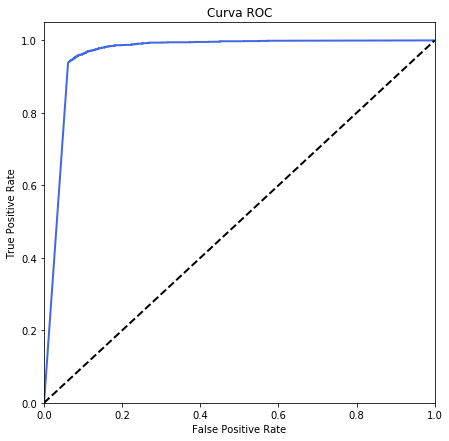

In [15]:
def baseline(X,Y):
    #Does the CV test for the Baseline
    print('Results from the Baseline:')
    train_results,test_results,y_correct,y_results,prob_results,clf = my_CV_train_test(GaussianNB,X,Y,{})
    #Calculate the Average Empirical Error
    train_results = np.array(train_results)
    mean = train_results.mean()
    std = train_results.std()
    print("Train: %0.3f (+/-%0.03f) for %s"  % (mean, std * 2, "Gaussian Naive Bayes"))
    #Calculate the Average Expected Error
    test_results = np.array(test_results)
    mean = test_results.mean()
    std = test_results.std()
    print("Test: %0.3f (+/-%0.03f) for %s"  % (mean, std * 2, "Gaussian Naive Bayes"))

    print()
    classes = ["FALSE POSITIVE", "CONFIRMED"]
    print(metrics.classification_report(y_correct, y_results, [0, 1], classes))
    create_roc_curve(y_correct, prob_results)
    
baseline(X,Y)

#### Resultados (Baseline):
O primeiro resultado que encontramos é o classificador que usamos de baseline, o Naive Bayes. Para esse dataset, somente com a validação cruzada 5-fold já que não variamos parâmetros, vemos que a acurácia medida pelo conjunto de teste é 0.915, ou 91.5 %. Esse resultado é consideravelmente bom, mostrando que a tarefa pode não ser tão difícil, já que o algoritmo relativamente simples teve um bom resultado. Além disso, como o erro empírico comparado com o erro esperado, respectivamente indicados pela acurácia no conjunto de treino e no conjunto de teste, tem uma baixa diferença, vemos que esse modelo provavelmente não teve overfitting. A precisão e revocação separada por classe mostra que esse modelo quando diz que um KOI não é um exoplaneta acerta bastante (0.98), mais que para a outra classe, mas quanto a revocação, os itens que são exoplanetas são mais classificados como exoplanetas (0.97), o contrário da precisão. A curva ROC mostra que esse classificador é bom, tendo uma curva bem próxima do ponto (0,1) de uma classificação perfeita.

### Outros Classificadores: 

#### Decision Tree:
Escolhemos para variar dois parâmetros, max_depth e max_features. A intenção é que possamos ter árvores que possam aprender a variação de todos as features, separando os dados até que cada instância dos dados seja uma folha, ou aprendendo só uma parte, parando num determinado nível. Tendo níveis o suficiente para analisar overfitting. Além de também avaliar a limitação ou não das escolhas de features usadas nas divisões da árvore em cada etapa. Para max_depth foram escolhidos os níveis de 5, 10, 50, 100 e o padrão do classificador, None (nenhum limite). O nível mínimo foi escolhido com base na documentação e exemplos da própria biblioteca scikit-learn, onde o mínimo usado é 5. Além disso, quando usamos juntamente ao número de features por decisão (max_features) igual a raiz do total (sendo $\sqrt{41} \approx 6.4$) temos um valor que permite que tenhamos uma árvore pequena, mas com uma quantidade justa de features possivelmente usadas, próxima ao valor disponível por etapa. Daí temos cada um dos outros valores múltiplos do nível mínimo, dobrando ele, depois subindo uma ordem de grandeza e dobrando novamente. Como temos 41 features, com certeza para 50 ou 100 níveis temos uma possibilidade maior de uso de todas elas em algum nível. Finalmente o nível None avalia o que acontece quando liberamos o classificador, sem nenhuma limitação de tamanho. Para max_features temos limites comuns como o logaritmo do número máximo de features, a raiz quadrada, além do padrão de nenhum limite.

Results from the parameter tests:
Train: 0.916 (+/-0.041) for {'max_depth': 5, 'max_features': 'sqrt'}
Test: 0.904 (+/-0.022) for {'max_depth': 5, 'max_features': 'sqrt'}
Train: 0.939 (+/-0.022) for {'max_depth': 5, 'max_features': 'log2'}
Test: 0.925 (+/-0.020) for {'max_depth': 5, 'max_features': 'log2'}
Train: 0.963 (+/-0.008) for {'max_depth': 5, 'max_features': None}
Test: 0.951 (+/-0.013) for {'max_depth': 5, 'max_features': None}
Train: 0.983 (+/-0.007) for {'max_depth': 10, 'max_features': 'sqrt'}
Test: 0.934 (+/-0.014) for {'max_depth': 10, 'max_features': 'sqrt'}
Train: 0.980 (+/-0.006) for {'max_depth': 10, 'max_features': 'log2'}
Test: 0.940 (+/-0.005) for {'max_depth': 10, 'max_features': 'log2'}
Train: 0.992 (+/-0.003) for {'max_depth': 10, 'max_features': None}
Test: 0.953 (+/-0.017) for {'max_depth': 10, 'max_features': None}
Train: 1.000 (+/-0.000) for {'max_depth': 50, 'max_features': 'sqrt'}
Test: 0.935 (+/-0.012) for {'max_depth': 50, 'max_features': 'sqrt'}
Train: 

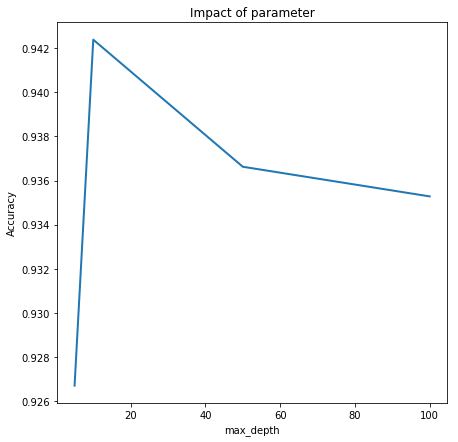

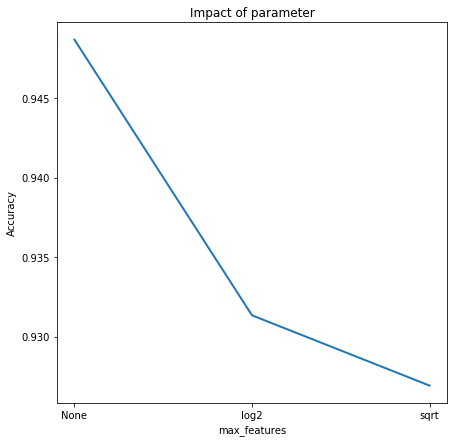

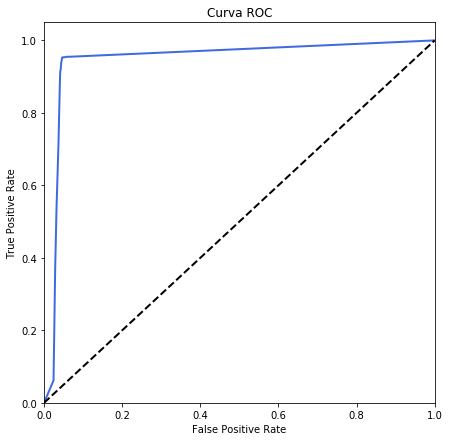

In [16]:
my_Grid_Search_CV(DecisionTreeClassifier,X,Y,{'max_depth':[5, 10, 50, 100, None], 'max_features':['sqrt', 'log2', None]})

#### Resultado (DT):
Os melhores parâmetros para o classificador Decision Tree foi a árvore de tamanho 10 e sem limite para as features usadas em cada nível da árvore, que obteve acurácia 0.953095, ou aproximadamente 95,3%. Esse valor, a precisão, a revocação e a curva ROC mostram um classificador melhor que o baseline do Naive Bayes. Esse classificador tem uma revocação melhor para a classe negativa do que o baseline, igualando-o à da classe positiva. A sua revocação dos FALSO POSITIVO é melhor que no baseline, mas é ligeiramente inferior ao valor do Naive Bayes para os exoplanetas de fato. Para precisão essas conclusões são inversas, com a classe positiva sendo mais precisamente classificada que no Naive Bayes. A curva ROC tem um formato mais pontudo, e com o ponto mais próximo do (0,1) tendo um x ligeiramente menor, mostrando que são necessários menos resultados falsos positivos para corretamente classificar exoplanetas. Quanto aos parâmetros, o resultado gráfico do desempenho médio do classificador quando ele possui cada configuração mostra que temos um pico de maior acurácia quando temos o limite de tamanho 10, sendo que aumentar esse limite ou diminuí-lo acarreta em perda de performance. Numa árvore binária de altura 10 temos entre 10 e 1024 nós folhas, o que indica que existe uma divisão dos dados numa quantidade de grupos entre esses valores que generaliza bem para o conjunto de dados de teste. Mais do que isso e começamos a ter overfitting do modelo. Para o parâmetro max_features, limitar o número de features disponíveis só reduz a performance, mostrando que o padrão do classificador é a melhor opção.

#### SVM:
Para o SVM realizaremos os testes para dois parâmetros, C, que afeta a penalidade dado pelo algoritmo para erros na classficação, e o kernel usado, que afeta como os dados são vistos pelo algoritmo. Como o enunciado já havia pedido os kernels em questão (linear, polinomial, rbf e sigmoid), apenas foram escolhidos os valores de C. Como C tem por padrão o valor de 1, realizamos testes para 0.1, 1 e 10, testando os resultados para uma ordem de grandeza maior ou menor que o valor padrão da biblioteca. Como nos testes só com esses 3 parâmetros quanto maior o valor de C, melhor para esse conjunto de dados, adicionamos também o valor 100, para avaliar se um aumento de ainda mais uma ordem de grandeza aumenta o desempenho.

Results from the parameter tests:
Train: 0.945 (+/-0.005) for {'C': 0.1, 'kernel': 'linear'}
Test: 0.944 (+/-0.014) for {'C': 0.1, 'kernel': 'linear'}
Train: 0.845 (+/-0.051) for {'C': 0.1, 'kernel': 'poly'}
Test: 0.846 (+/-0.066) for {'C': 0.1, 'kernel': 'poly'}
Train: 0.922 (+/-0.002) for {'C': 0.1, 'kernel': 'rbf'}
Test: 0.920 (+/-0.012) for {'C': 0.1, 'kernel': 'rbf'}
Train: 0.894 (+/-0.009) for {'C': 0.1, 'kernel': 'sigmoid'}
Test: 0.893 (+/-0.024) for {'C': 0.1, 'kernel': 'sigmoid'}
Train: 0.955 (+/-0.002) for {'C': 1, 'kernel': 'linear'}
Test: 0.952 (+/-0.007) for {'C': 1, 'kernel': 'linear'}
Train: 0.892 (+/-0.002) for {'C': 1, 'kernel': 'poly'}
Test: 0.882 (+/-0.012) for {'C': 1, 'kernel': 'poly'}
Train: 0.943 (+/-0.002) for {'C': 1, 'kernel': 'rbf'}
Test: 0.935 (+/-0.013) for {'C': 1, 'kernel': 'rbf'}
Train: 0.834 (+/-0.023) for {'C': 1, 'kernel': 'sigmoid'}
Test: 0.829 (+/-0.028) for {'C': 1, 'kernel': 'sigmoid'}
Train: 0.959 (+/-0.001) for {'C': 10, 'kernel': 'linear'}
Test

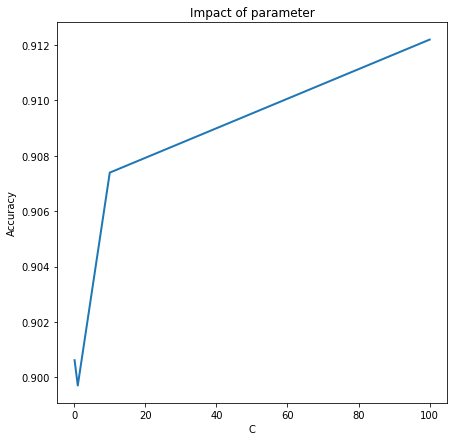

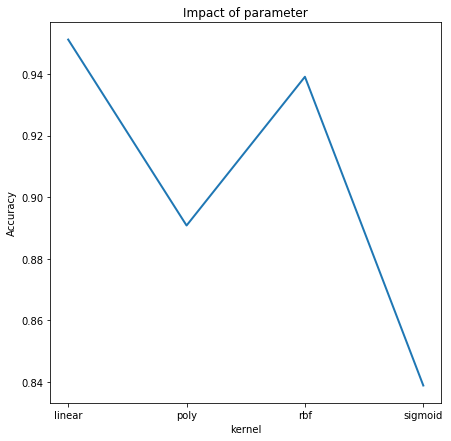

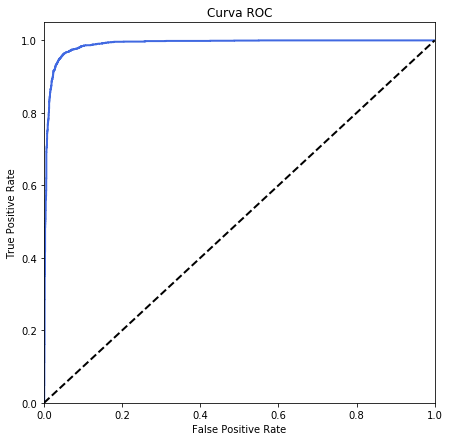

In [17]:
my_Grid_Search_CV(SVC,X,Y,{'C': [0.1, 1,10,100],'kernel':['linear','poly','rbf','sigmoid']},{'gamma': 'scale','probability':True})

#### Resultado (SVM):
Com uma acurácia de 0.955017, ou aproximadamente 95.5%, a melhor combinação de parâmetros para o SVM foi o kernel linear com C = 100. Sua precisão e revocação tem resultados próximos do classificador Decision Tree, com uma precisão para a classe negativa, e uma revocação para a classe positiva, ligeiramente maiores. Sua curva ROC também é melhor, tendo um contato da curva com o eixo y, indicando que com 0 erro de falso positivo, já temos acertos do classificador. O kernel linear tem o melhor resultado comparando as médias do SVM com cada kernel. O ranking dos outros kernels é rbf, polinomial e sigmoid, sendo o rbf bem próximo do linear. Como o C melhora com o aumento do valor, procurar uma margem minima maior (o que é o foco do SVM quando temos C relativamente pequenos) não é tão importante quanto achar uma divisão que separe bem os dados. Como a diferença entre erro empírico e erro esperado não é tão grande para C=100, principalmente para o kernel linear e sigmoid, vemos que não estamos caminhando para um overfitting aumentando o C para esses kernels, mas ajustando o modelo as peculiaridades dos dados. Ou seja, ao permitir uma margem menor para esses dados não necessariamente estamos perdendo generalização.

#### KNN:
Para o KNN variamos os valores de apenas um parâmetro, o número de vizinhos levados em consideração para a descoberta da classe de uma instância de dados. Foi avaliado o uso de diferentes métricas de distância, mas não houve melhora significativa, tendo a métrica de cosseno tendo uma melhora de 0.006 na acurácia. O valor padrão dado pela biblioteca para número de vizinhos é 5, mas reduzimos o valor mínimo para 3, com o objetivo de testar como o classificador se comporta com o mínimo de dados. Não consideramos 1 ou 2 pois são valores pequenos demais, e no caso de 2 pode haver um empate com muito mais frequência do que para números pares maiores. Além dele, testamos para o dobro do valor padrão e para uma e duas ordens de grandeza maiores. Esperamos com isso avaliar o quanto a vizinhança de fato diz respeito da classe de seus vizinhos, o que é medido por esse parâmetro.

Results from the parameter tests:
Train: 0.935 (+/-0.004) for {'n_neighbors': 3}
Test: 0.892 (+/-0.023) for {'n_neighbors': 3}
Train: 0.920 (+/-0.004) for {'n_neighbors': 5}
Test: 0.891 (+/-0.016) for {'n_neighbors': 5}
Train: 0.910 (+/-0.005) for {'n_neighbors': 10}
Test: 0.895 (+/-0.020) for {'n_neighbors': 10}
Train: 0.864 (+/-0.005) for {'n_neighbors': 50}
Test: 0.858 (+/-0.014) for {'n_neighbors': 50}
Train: 0.843 (+/-0.007) for {'n_neighbors': 100}
Test: 0.838 (+/-0.013) for {'n_neighbors': 100}

Best Parameters (0.894656 accuracy): {'n_neighbors': 10}

                precision    recall  f1-score   support

FALSE POSITIVE       0.97      0.85      0.91      3098
     CONFIRMED       0.81      0.97      0.88      2104

     micro avg       0.89      0.89      0.89      5202
     macro avg       0.89      0.91      0.89      5202
  weighted avg       0.91      0.89      0.90      5202



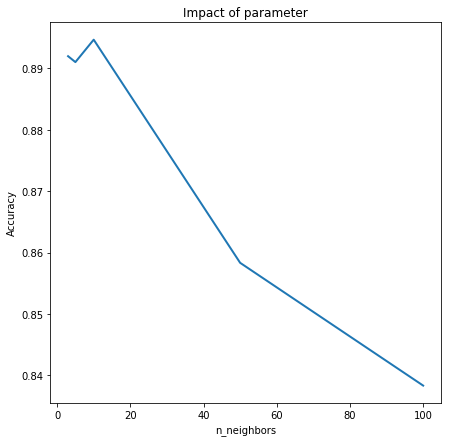

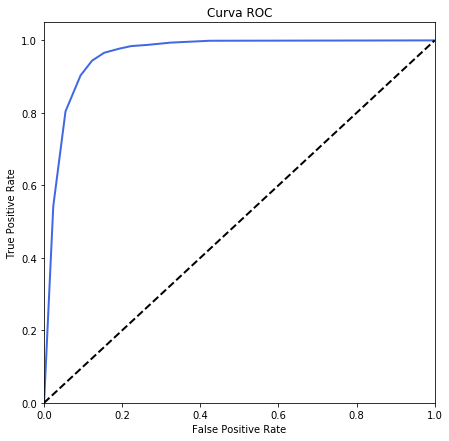

In [18]:
my_Grid_Search_CV(KNeighborsClassifier,X,Y,{'n_neighbors': [3,5,10,50,100]})

#### Resultado (KNN):
O resultado encontrado com o melhor valor de k_neighbors (10) não é melhor que o baseline, com uma acurácia média de 0.894656, ou aproximadamente 89.5%, sendo não necessariamente pior já que o intervalo do seu desvio padrão alcança o valor da acurácia média do Naive Bayes. Sua precisão da classe positiva e revocação da classe negativa são um pouco piores, também tendo uma curva ROC mais distante de uma classificação perfeita e mais arredondada que a curva ROC do baseline. Vemos pelo gráfico da variação do parâmetro que existe um pico com 10 vizinhos sendo usados para determinar a classe dos itens de dados, e um aumento desse número só piora o desempenho. Isso mostra que os dados provavelmente estão bem próximos, com provável mistura entre as duas classes, o que corrobora o resultado do SVM, em que os kernels linear e rbf com C relativamente grande tem melhores desempenhos.

#### Random Forest:
Para o classificador Random Forest também apenas alteraremos um parâmetro, o número de árvores que serão usadas na "floresta". Novamente começamos avaliando o valor padrão, que nesse caso é 10. Testando novamente uma e duas ordens de grandeza maiores esperamos que o bagging se aprofunde mais nos dados, já que com 1000 árvores temos a mesma ordem que a quantidade de dados. Com testes desses valores vemos que o Random Forest já tem 100% de acurácia no conjunto de treino, na maioria das vezes já no valor igual a 100. Dessa forma resolvemos aprofundar a quantidade de opções entre 10 e 100, colocando um quarto e metade do valor mais alto, refinando a análise do parâmetro nessa região.

Results from the parameter tests:
Train: 0.998 (+/-0.001) for {'n_estimators': 10}
Test: 0.964 (+/-0.009) for {'n_estimators': 10}
Train: 0.999 (+/-0.000) for {'n_estimators': 25}
Test: 0.968 (+/-0.007) for {'n_estimators': 25}
Train: 1.000 (+/-0.000) for {'n_estimators': 50}
Test: 0.969 (+/-0.008) for {'n_estimators': 50}
Train: 1.000 (+/-0.000) for {'n_estimators': 100}
Test: 0.968 (+/-0.006) for {'n_estimators': 100}
Train: 1.000 (+/-0.000) for {'n_estimators': 1000}
Test: 0.971 (+/-0.006) for {'n_estimators': 1000}

Best Parameters (0.970588 accuracy): {'n_estimators': 1000}

                precision    recall  f1-score   support

FALSE POSITIVE       0.98      0.97      0.98      3098
     CONFIRMED       0.96      0.96      0.96      2104

     micro avg       0.97      0.97      0.97      5202
     macro avg       0.97      0.97      0.97      5202
  weighted avg       0.97      0.97      0.97      5202



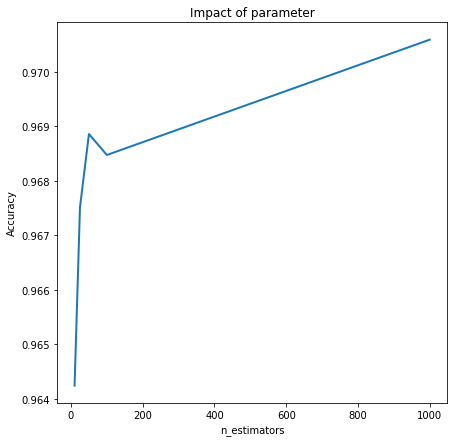

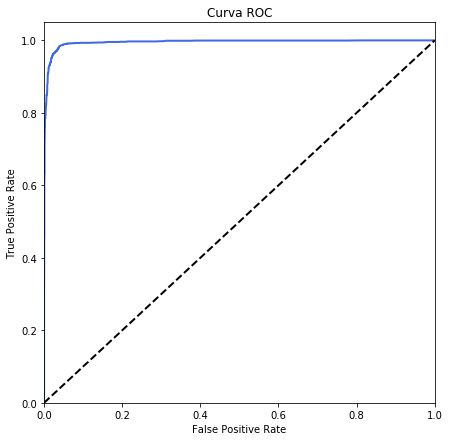

In [19]:
my_Grid_Search_CV(RandomForestClassifier,X,Y,{'n_estimators':[10, 25, 50, 100, 1000]})

#### Resultados (RF):
O classificador Random Forest, uma técnica de bagging utilizando árvores de decisão, alcança uma melhora comparado aos dos melhores resultados até agora, do classificador de árvores de decisão, reforçando seu resultado. Com acurácia de 0.970588, ou aproximadamente 97%, temos como aparente melhor parâmetro o uso de 1000 árvores de decisão. Os valores de precisão e revocação, além da curva ROC, são os melhores de todos os classificadores anteriores, sendo a curva ROC particularmente impressionante por mostrar que o método consegue com 0 erro de falsos positivos classificar com quase 80% de taxa de positivos verdadeiros, um ótimo resultado. O fato de termos como melhor valor o máximo testado para o parâmetro mostra que talvez haja ainda espaço para melhorar ainda mais o resultado deste algoritmo. Todavia foi necessário aumentar em 20 vezes o número de árvores para um acréscimo de 0.002 de acurácia, acréscimo esse dentro da diferença do desvio padrão. Pelo erro empírico igual a 0 encontrado, temos que o conjunto de dados foi complemente separado por esse método, mas como temos uma taxa de acurácia não cresce tanto, o resultado encontrado para 1000 árvores é praticamente empatado com o para 100, 50, 25 e até 10 árvores, sendo que a diferença entre erro empírico e esperado é menor para 1000 árvores podemos dizer que esse é o melhor resultado em termos de overfitting. Isso faz sentido já que o bagging evita que tenhamos os dados memorizados pelo método.

#### Gradient Boosting Trees:
Para a técnica de boosting utilizada, também avaliaremos a variação do número de árvores usadas no classificador. Isso foi escolhido dessa forma já que o enunciado havia pedido a análise do número de iterações do boosting, que em si, é um processo de refinamento do treinamento de uma árvore de decisão (normalmente) por outra árvore, e o número de árvores foi o parâmetro mais claramente envolvido nessa quantidade. O valor padrão para o parâmetro avaliado, n_estimators, é 100. Avaliamos uma ordem de grandeza a mais e uma a menos (metade do padrão). Também adicionamos um valor intermediário entre 100 e 1000 para avaliar como é a evolução da acurácia nesse intervalo, além do valor máximo 5000 que é um arredondamento do número de itens de dados, avaliando a acurácia com árvores o suficiente para praticamente avaliar cada item em uma iteração.

Results from the parameter tests:
Train: 0.980 (+/-0.002) for {'n_estimators': 50}
Test: 0.968 (+/-0.008) for {'n_estimators': 50}
Train: 0.991 (+/-0.001) for {'n_estimators': 100}
Test: 0.972 (+/-0.008) for {'n_estimators': 100}
Train: 1.000 (+/-0.000) for {'n_estimators': 500}
Test: 0.975 (+/-0.008) for {'n_estimators': 500}
Train: 1.000 (+/-0.000) for {'n_estimators': 1000}
Test: 0.976 (+/-0.008) for {'n_estimators': 1000}
Train: 1.000 (+/-0.000) for {'n_estimators': 5000}
Test: 0.976 (+/-0.009) for {'n_estimators': 5000}

Best Parameters (0.975971 accuracy): {'n_estimators': 1000}

                precision    recall  f1-score   support

FALSE POSITIVE       0.99      0.97      0.98      3098
     CONFIRMED       0.96      0.98      0.97      2104

     micro avg       0.98      0.98      0.98      5202
     macro avg       0.97      0.98      0.98      5202
  weighted avg       0.98      0.98      0.98      5202



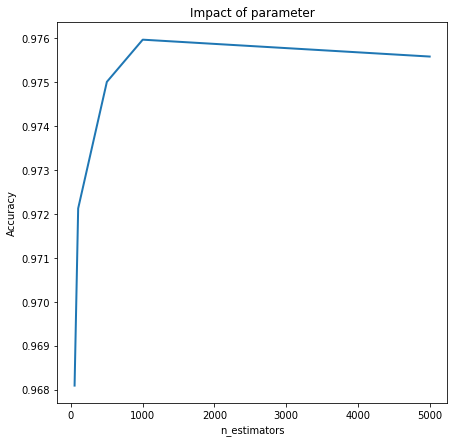

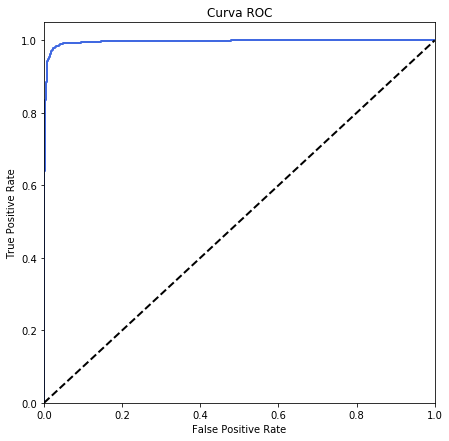

In [20]:
my_Grid_Search_CV(GradientBoostingClassifier,X,Y,{'n_estimators':[50, 100, 500, 1000, 5000]})

#### Resultados (GBT):
Para este último classificador temos um resultado muito semelhante ao anterior, onde o uso de árvores de decisão também ocorre. No Gradient Boosting Trees temos o uso de Boosting, como diz o nome, onde em lugar de treinar várias árvores com diferentes partes dos dados, temos árvores treinando nesse conjunto usando pesos diferentes em cada item de acordo com o erro da árvore da iteração anterior. O melhor valor de acurácia encontrado foi de 0.975971, ou aproximadamente 97.6%, mas considerando o desvio padrão, sem significante diferença com o Random Forest. Ainda assim o resultado é fora do desvio dos outros classificadores, sendo que com rigor estatístico de um teste t com 95% de confiança não há real diferença entre esse método e nenhum dos outros classificadores, exceto o KNN e o Naive Bayes. Todavia esse ainda é o maior valor encontrado, com o número de iterações igual a 1000. Como dito, a precisão e revocação é semelhante ao Random Forest, tendo uma curva ROC praticamente igual, com uma interseção com o eixo x um pouco pior. Quanto ao overfitting, vemos que por mais que o classificador alcançou 100% de acurácia no conjunto de treino, ainda houve crescimento da acurácia até n_estimators = 1000. Assim, a capacidade ótima para esse método parace ser próximo de 1000 árvores de decisão. Todavia, como as diferenças estão dentro do desvio, talvez com menos árvores o Gradient Boosting Trees consegue o mesmo que o bagging do Random Forests, e que ainda podemos diminuir ainda mais o número necessário sem perder a performance, dentro do desvio padrão.

### Versão dos dados reduzida:
Agora com os resultados em mãos para todos as features, vamos também avaliar como são os resultados com o uso de feature seletion. Para determinar o número de features usadas, foram testados valores em ordens de grandeza diferentes e avaliado o resultado do baseline quando alterávamos tal valor. Com metade dos dados a acurácia praticamente se mantinha, então foi feito um refinamento até alcançar 25 features como o menor valor que mantinha o mesmo resultado do baseline. Seria possível o uso de PCA para um resultado mais automatizado encontrando o número final de dimensões com base na variância capturada automaticamente, mas como o PCA não fez parte da matéria até o momento foi escolhido o uso da função usada na aula prática, com esse teste empírico descrito acima. Os valores dos parâmetros testados permanecem os mesmos.

#### Naive Bayes (Baseline):

Results from the Baseline:
Train: 0.916 (+/-0.007) for Gaussian Naive Bayes
Test: 0.916 (+/-0.007) for Gaussian Naive Bayes

                precision    recall  f1-score   support

FALSE POSITIVE       0.97      0.88      0.93      3098
     CONFIRMED       0.85      0.96      0.90      2104

     micro avg       0.92      0.92      0.92      5202
     macro avg       0.91      0.92      0.91      5202
  weighted avg       0.92      0.92      0.92      5202



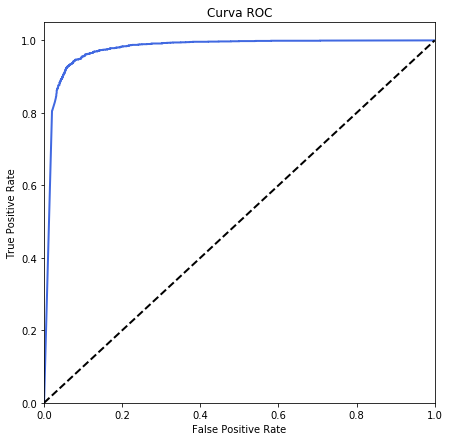

In [21]:
baseline(X_reduced,Y)

#### Resultados (Baseline):
Como era o que testamos, o resultado do Baseline se mantém inalterado comparado com usando todos os dados.

#### Decision Tree:

Results from the parameter tests:
Train: 0.926 (+/-0.046) for {'max_depth': 5, 'max_features': 'sqrt'}
Test: 0.917 (+/-0.028) for {'max_depth': 5, 'max_features': 'sqrt'}
Train: 0.921 (+/-0.019) for {'max_depth': 5, 'max_features': 'log2'}
Test: 0.907 (+/-0.024) for {'max_depth': 5, 'max_features': 'log2'}
Train: 0.962 (+/-0.005) for {'max_depth': 5, 'max_features': None}
Test: 0.946 (+/-0.008) for {'max_depth': 5, 'max_features': None}
Train: 0.987 (+/-0.003) for {'max_depth': 10, 'max_features': 'sqrt'}
Test: 0.942 (+/-0.014) for {'max_depth': 10, 'max_features': 'sqrt'}
Train: 0.985 (+/-0.003) for {'max_depth': 10, 'max_features': 'log2'}
Test: 0.941 (+/-0.016) for {'max_depth': 10, 'max_features': 'log2'}
Train: 0.991 (+/-0.005) for {'max_depth': 10, 'max_features': None}
Test: 0.948 (+/-0.013) for {'max_depth': 10, 'max_features': None}
Train: 1.000 (+/-0.000) for {'max_depth': 50, 'max_features': 'sqrt'}
Test: 0.936 (+/-0.014) for {'max_depth': 50, 'max_features': 'sqrt'}
Train: 

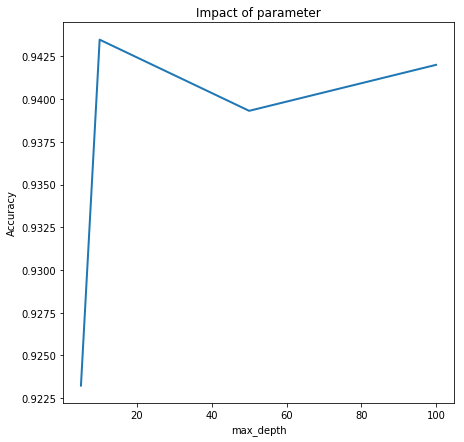

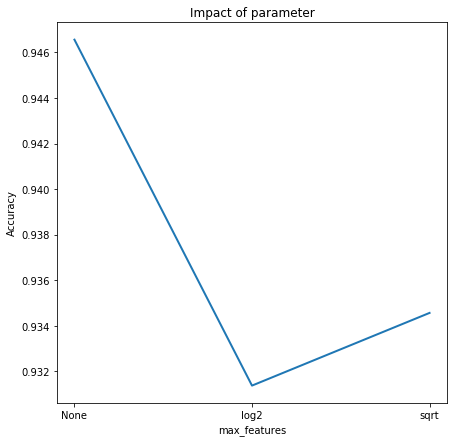

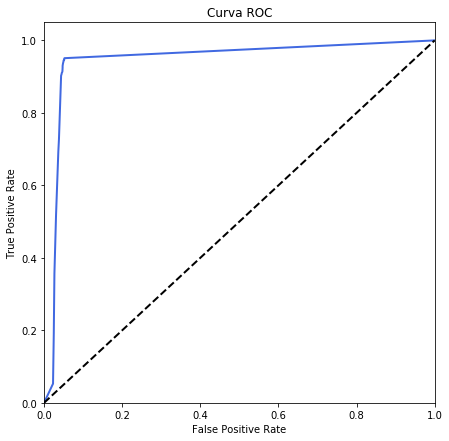

In [22]:
my_Grid_Search_CV(DecisionTreeClassifier,X_reduced,Y,{'max_depth':[5, 10, 50, 100, None], 'max_features':['sqrt', 'log2', None]})

#### SVM:

Results from the parameter tests:
Train: 0.868 (+/-0.005) for {'C': 0.1, 'kernel': 'linear'}
Test: 0.867 (+/-0.018) for {'C': 0.1, 'kernel': 'linear'}
Train: 0.596 (+/-0.000) for {'C': 0.1, 'kernel': 'poly'}
Test: 0.596 (+/-0.000) for {'C': 0.1, 'kernel': 'poly'}
Train: 0.854 (+/-0.005) for {'C': 0.1, 'kernel': 'rbf'}
Test: 0.852 (+/-0.012) for {'C': 0.1, 'kernel': 'rbf'}
Train: 0.794 (+/-0.005) for {'C': 0.1, 'kernel': 'sigmoid'}
Test: 0.793 (+/-0.021) for {'C': 0.1, 'kernel': 'sigmoid'}
Train: 0.911 (+/-0.005) for {'C': 1, 'kernel': 'linear'}
Test: 0.910 (+/-0.019) for {'C': 1, 'kernel': 'linear'}
Train: 0.617 (+/-0.003) for {'C': 1, 'kernel': 'poly'}
Test: 0.616 (+/-0.011) for {'C': 1, 'kernel': 'poly'}
Train: 0.908 (+/-0.005) for {'C': 1, 'kernel': 'rbf'}
Test: 0.905 (+/-0.022) for {'C': 1, 'kernel': 'rbf'}
Train: 0.896 (+/-0.001) for {'C': 1, 'kernel': 'sigmoid'}
Test: 0.896 (+/-0.014) for {'C': 1, 'kernel': 'sigmoid'}
Train: 0.928 (+/-0.005) for {'C': 10, 'kernel': 'linear'}
Test

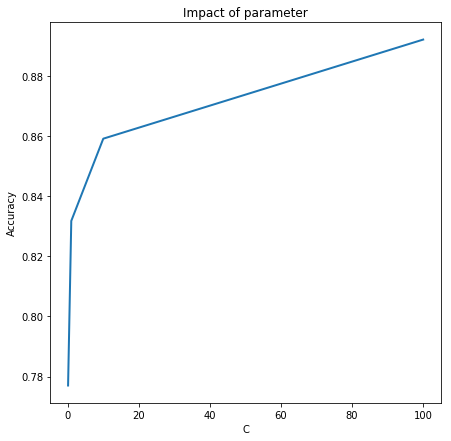

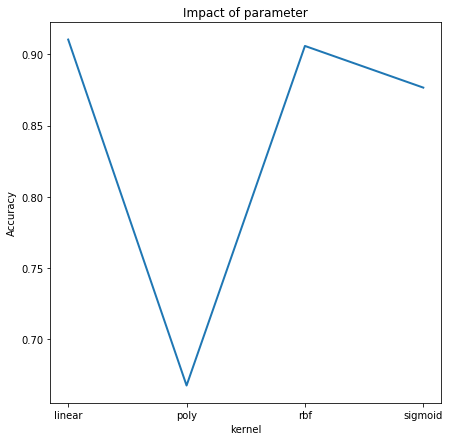

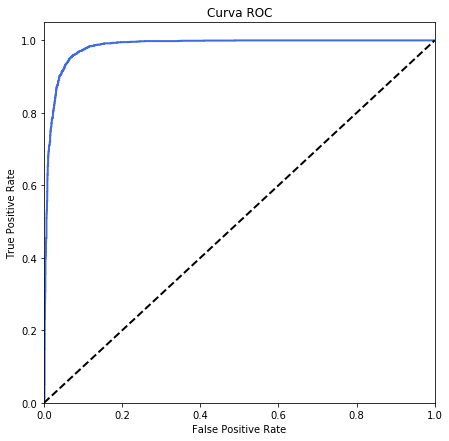

In [23]:
my_Grid_Search_CV(SVC,X_reduced,Y,{'C': [0.1, 1,10,100],'kernel':['linear','poly','rbf','sigmoid']},{'gamma': 'scale','probability':True})

#### KNN:

Results from the parameter tests:
Train: 0.926 (+/-0.005) for {'n_neighbors': 3}
Test: 0.859 (+/-0.016) for {'n_neighbors': 3}
Train: 0.900 (+/-0.006) for {'n_neighbors': 5}
Test: 0.860 (+/-0.016) for {'n_neighbors': 5}
Train: 0.890 (+/-0.007) for {'n_neighbors': 10}
Test: 0.865 (+/-0.015) for {'n_neighbors': 10}
Train: 0.856 (+/-0.007) for {'n_neighbors': 50}
Test: 0.849 (+/-0.023) for {'n_neighbors': 50}
Train: 0.840 (+/-0.007) for {'n_neighbors': 100}
Test: 0.835 (+/-0.022) for {'n_neighbors': 100}

Best Parameters (0.865052 accuracy): {'n_neighbors': 10}

                precision    recall  f1-score   support

FALSE POSITIVE       0.93      0.84      0.88      3098
     CONFIRMED       0.79      0.90      0.84      2104

     micro avg       0.87      0.87      0.87      5202
     macro avg       0.86      0.87      0.86      5202
  weighted avg       0.87      0.87      0.87      5202



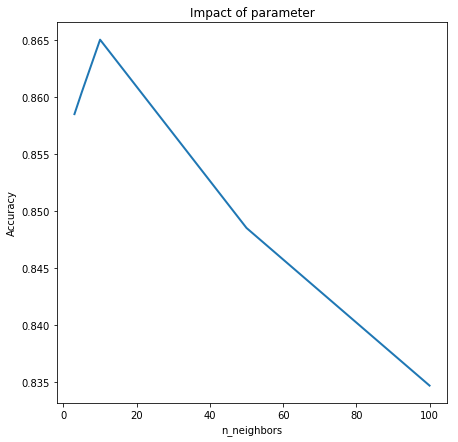

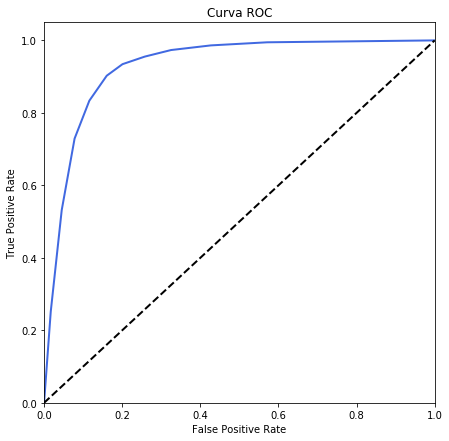

In [24]:
my_Grid_Search_CV(KNeighborsClassifier,X_reduced,Y,{'n_neighbors': [3,5,10,50,100]})

#### Random Forest:

Results from the parameter tests:
Train: 0.998 (+/-0.002) for {'n_estimators': 10}
Test: 0.962 (+/-0.008) for {'n_estimators': 10}
Train: 1.000 (+/-0.001) for {'n_estimators': 25}
Test: 0.967 (+/-0.003) for {'n_estimators': 25}
Train: 1.000 (+/-0.000) for {'n_estimators': 50}
Test: 0.969 (+/-0.009) for {'n_estimators': 50}
Train: 1.000 (+/-0.000) for {'n_estimators': 100}
Test: 0.970 (+/-0.005) for {'n_estimators': 100}
Train: 1.000 (+/-0.000) for {'n_estimators': 1000}
Test: 0.970 (+/-0.006) for {'n_estimators': 1000}

Best Parameters (0.970396 accuracy): {'n_estimators': 1000}

                precision    recall  f1-score   support

FALSE POSITIVE       0.97      0.98      0.98      3098
     CONFIRMED       0.96      0.96      0.96      2104

     micro avg       0.97      0.97      0.97      5202
     macro avg       0.97      0.97      0.97      5202
  weighted avg       0.97      0.97      0.97      5202



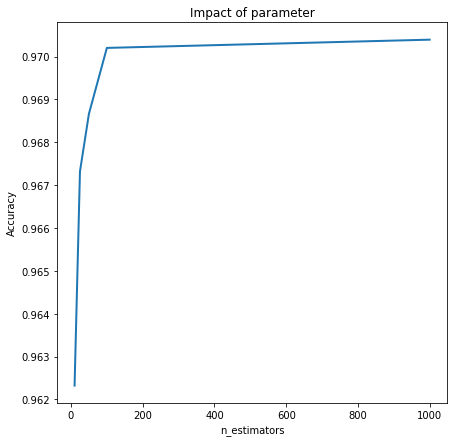

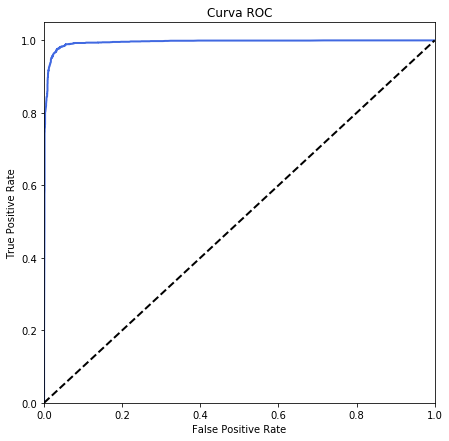

In [25]:
my_Grid_Search_CV(RandomForestClassifier,X_reduced,Y,{'n_estimators':[10, 25, 50, 100,1000]})

#### Gradient Boosting Trees:

Results from the parameter tests:
Train: 0.978 (+/-0.003) for {'n_estimators': 50}
Test: 0.966 (+/-0.008) for {'n_estimators': 50}
Train: 0.989 (+/-0.001) for {'n_estimators': 100}
Test: 0.969 (+/-0.008) for {'n_estimators': 100}
Train: 1.000 (+/-0.000) for {'n_estimators': 500}
Test: 0.973 (+/-0.008) for {'n_estimators': 500}
Train: 1.000 (+/-0.000) for {'n_estimators': 1000}
Test: 0.974 (+/-0.009) for {'n_estimators': 1000}
Train: 1.000 (+/-0.000) for {'n_estimators': 5000}
Test: 0.973 (+/-0.009) for {'n_estimators': 5000}

Best Parameters (0.974048 accuracy): {'n_estimators': 1000}

                precision    recall  f1-score   support

FALSE POSITIVE       0.98      0.97      0.98      3098
     CONFIRMED       0.96      0.98      0.97      2104

     micro avg       0.97      0.97      0.97      5202
     macro avg       0.97      0.97      0.97      5202
  weighted avg       0.97      0.97      0.97      5202



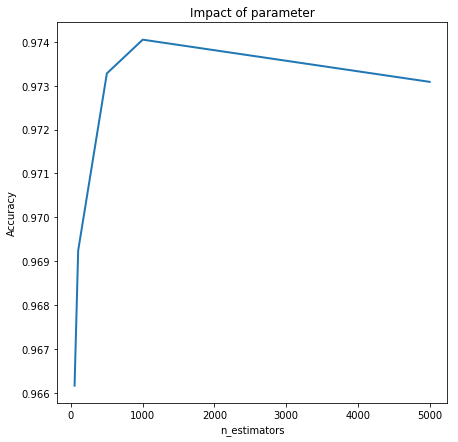

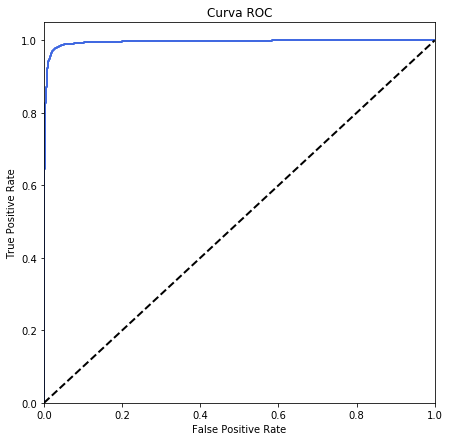

In [26]:
my_Grid_Search_CV(GradientBoostingClassifier,X_reduced,Y,{'n_estimators':[50, 100, 500, 1000, 5000]})

#### Resultados (Versão Reduzida):
Ao realizar a redução da dimensionalidade dos dados pela metade ainda podemos ver que o desempenho não é alterado dentro do desvio padrão. Ainda assim, existe uma igual queda na média e aumento do desvio para todos os algoritmos, exceto no desvio do KNN. Dessa forma vemos que uma redução maior não tende a melhorar os resultados, apesar de que com metade das dimensões espera-se ter uma execução mais rápida. Os melhores valores para os parâmetros se mantem, assim como as curvas de alteração da acurácia em relação a essas mudanças, com apenas um caso de interessse diferente, onde o kernel rbf se torna ainda mais próximo do kernel linear no SVM, indicando que provavelmente com ainda menos dimensões esse kernel pode se tornar o melhor, todavia, como a nova acurácia é de 0.939 para o SVM, ele não deve superar o classificador Random Forest ou Gradient Boosting Trees com todos os dados. O fato do método ser capaz de alcançar 100% de acurácia no treino, assim como o Random Forest, reforça a ideia, também indicada pelo baseline, de que esse conjunto de dados é relativamente fácil de ser separado.

## Conclusão
Considerando que todos os classificadores com árvores de decisão (DT, RF e GBT) tiveram ótimos desempenhos vemos que os dados são bem separados por essa categoria de métodos. SVM também é capaz de separar de forma equivalente ao Decision Tree com aproximadamente o mesmo nível de acurácia, e também uma boa curva ROC. Gradient Boosting Trees tem ótimos resultados de precisão e revocação, sendo a segunda melhor curva ROC, praticamente empatado com a curva do Random Forest, que é a melhor. 

A grande diferença entre esses algoritmos é a forma com que os dados são interpretados. Para o Naive Bayes tratamos dados numa visão probabilística, tentando prever através das probabilidades de um dado valor em uma feature, qual classe um item de dados pode ter. Essa visão tem um resultado razoável, e tem uma grande rapidez, além de ser um método não paramétrico. Todavia os outros métodos o superam, principalmente os métodos de árvores de decisão, onde vemos os melhores resultados em geral, e que tratam cada feature como uma possível forma de dividir os dados. Essa forma de divisão consegue separar de forma bem específica nas várias dimensões existentes os dados, sendo capaz de separar dado a dado com árvores grandes o suficiente, ou no caso do boosting/bagging, atráves de combinação de árvores simples. Esse resultado não é surpreendente, mas demonstra a forma como os tipos de classificadores atuam em dados como os disponíveis para esse trabalho. O SVM que atua numa visão mais geométrica/vetorial dos dados, também tem um grande apelo com a possibilidade de alterar a visão dos dados através de kernels. Dentro dos desvios alcançou, ainda que por muito pouco, mesmo o melhor dos classificadores, mostrando que essa visão geométrica também é bem poderosa aliada ao kernel e a margem de erro certa. O parâmetro C tem grande importância em sua capacidade de alterar o foco do algoritmo na busca por uma margem mínima maior, ou na clara separação das classes. Essa visão geométrica, porém, não é boa em todos as suas formas. O pior algoritmo, o KNN, indica o que o valor de C também já apontava, que provavelmente os dados estão misturados, e portanto os pontos de dados vizinhos não são bons indicadores da classe de um outro ponto. A escolha do método correto, das boas práticas de uso da validação cruzada que permitem também até testes estatísticos, além da clara medição dos erros empíricos e esperados, mostram como podemos criar bons classificadores com facilidade, se utilizando dos hiperparâmetros para refinar os diversos métodos, deixando claro quando um classificador pode estar sendo focado demais no treino, e não necessariamente tendo um bom resultado.